In [79]:
# pip
# !pip install tqdm
# !pip install dask
# !pip install apache-sedona
# !pip install shapely
# !pip install geopandas
# !pip install leafmap
!pip install openpyxl

     -------------------------------------- 250.0/250.0 kB 1.3 MB/s eta 0:00:00


In [ ]:
# conda
# !conda install tqdm
# !conda install dask
#!conda install findspark

In [74]:
from sedona.register import SedonaRegistrator  
from sedona.utils import SedonaKryoRegistrator, KryoSerializer
import geopandas as gpd
from shapely.geometry import Point, Polygon
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from haversine import haversine, Unit
import pyspark.sql.types as types
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import leafmap

In [ ]:
# configuration, worked on using python@3.10.9 
import os
import urllib
import json
from threading import Thread, Lock
from tqdm import tqdm
from kafka import KafkaConsumer, KafkaProducer
import pyspark
import pandas

In [ ]:
conf = pyspark.SparkConf()\
    .setMaster("local[7]")\
    .set("spark.eventLog.enabled", "true")\
    .set("spark.eventLog.dir", "./logs")\
    .set("spark.eventLog.gcMetrics.youngGenerationGarbageCollectors", "true")\
    .set("spark.executor.heartbeatInterval","3600s")\
    .set("spark.network.timeout","3601s")\
    .set("spark.sql.repl.eagerEval.enabled", False)
    # .set("spark.kryo.registrator", SedonaKryoRegistrator.getName)\
    # .set("spark.kryo.registrator", SedonaKryoRegistrator.getName)\
    # .set('spark.jars.packages',
           # 'org.apache.sedona:sedona-spark-shaded-3.0_2.12:1.4.0,'
           # 'org.datasyslab:geotools-wrapper:1.4.0-28.2')

'''
sparkSession = SparkSession. \
    builder. \
    appName('appName'). \
    config("spark.serializer", KryoSerializer.getName). \
    config("spark.kryo.registrator", SedonaKryoRegistrator.getName). \
    config('spark.jars.packages',
           'org.apache.sedona:sedona-spark-shaded-3.0_2.12:1.4.0,'
           'org.datasyslab:geotools-wrapper:1.4.0-28.2'). \
    getOrCreate()
'''

sc = pyspark.SparkContext(conf=conf)
sc.setLogLevel('ERROR')
spark = pyspark.sql.SparkSession(sc)
spark

In [ ]:
# SedonaRegistrator.registerAll(spark)

In [ ]:
# data folder
data_dir = 'data'

# data urls
historic_arrest_loc = { 'url': 'https://data.cityofnewyork.us/resource/8h9b-rp9u.json?$limit=10', 'filename': 'lil_arrest.json' }
historic_complaint_loc = { 'url': 'https://data.cityofnewyork.us/resource/qgea-i56i.json?$limit=15000000', 'filename': 'complaint.json' }
historic_court_summons_loc = { 'url': 'https://data.cityofnewyork.us/resource/sv2w-rv3k.json?$limit=10', 'filename': 'lil_summons.json' }
traffic_speed_loc = { 'url': 'https://data.cityofnewyork.us/resource/i4gi-tjb9.json?$limit=15000000', 'filename': 'speed.json' }
turnstile_loc = { 'url': 'https://data.ny.gov/resource/i55r-43gk.json?$limit=15000000', 'filename': 'turnstile.json' }
#subway_loc = { 'url': 'https://data.ny.gov/resource/i9wp-a4ja.json?$limit=15000000', 'filename': 'subway.json' }
subway_loc = { 'url': 'http://web.mta.info/developers/data/nyct/subway/Stations.csv?$limit=15000000', 'filename': 'subway.csv' }

In [ ]:
# download flags
downloadflag = True
redownload = False

thread_lock = Lock()

# download utils
def download_dataset_thread(loc, folder):
    with thread_lock:
         if ((not os.path.exists(os.path.join(folder, loc['filename']))) or redownload) and downloadflag:
            if os.path.isfile(os.path.join(folder, loc['filename'])):
                os.remove(os.path.join(folder, loc['filename']))
            if not os.path.exists(folder):
                os.makedirs(folder) 
            with tqdm(unit="B", unit_scale=True, desc=loc['filename'], miniters=1) as progress_bar:
                urllib.request.urlretrieve(loc['url'], os.path.join(folder, loc['filename']), lambda block_num, block_size, total_size: progress_bar.update(block_size))
            progress_bar.display()
        
def download_dataset(loc, folder):
    thread = Thread(target=download_dataset_thread, args=(loc, folder))
    thread.start()
    thread.join()
        

In [ ]:
# download datasets
for dataset in [historic_arrest_loc,
                historic_complaint_loc,
                historic_court_summons_loc,
                turnstile_loc,
                subway_loc]:
    download_dataset(dataset, data_dir)

In [ ]:
# dataframes
arrest_rdd = spark.read.json(os.path.join(data_dir, historic_arrest_loc['filename']), multiLine=True)
complaint_rdd = spark.read.json(os.path.join(data_dir, historic_complaint_loc['filename']), multiLine=True)
summons_rdd = spark.read.json(os.path.join(data_dir, historic_court_summons_loc['filename']), multiLine=True)
turnstile_rdd = spark.read.json(os.path.join(data_dir, turnstile_loc['filename']), multiLine=True)
subway_rdd = spark.read.csv(os.path.join(data_dir, subway_loc['filename']), header=True, inferSchema=True)

In [ ]:
#subway_rdd = spark.read.json(os.path.join(data_dir, subway_loc['filename']), multiLine=True)
subway_rdd = spark.read.csv(os.path.join(data_dir, subway_loc['filename']), header=True, inferSchema=True)

In [ ]:
arrest_rdd = spark.read.json(os.path.join(data_dir, historic_arrest_loc['filename']), multiLine=True)

In [ ]:
summons_rdd = spark.read.json(os.path.join(data_dir, historic_court_summons_loc['filename']), multiLine=True)

In [ ]:
lil_summons_rdd = spark.read.json(os.path.join(data_dir, historic_court_summons_loc['filename']), multiLine=True)

In [ ]:
lil_arrest_rdd = spark.read.json(os.path.join(data_dir, historic_arrest_loc['filename']), multiLine=True)

In [ ]:
# subway_DF = subway_rdd.toDF("ada", "ada_notes", "corner", "division", "east_west_street", "entrance_georeference", "entrance_latitude", "entrance_location", "entrance_longitude", "entrance_type", "entry", "exit_only", "free_crossover", "line", "north_south_street", "route1", "route10", "route11", "route2", "route3", "route4", "route5", "route6", "route7", "route8", "route9", "staff_hours", "staffing", "station_georeference", "station_latitude", "station_location", "station_longitude", "station_name", "vending")
subway_DF = subway_rdd.toDF("Station ID", "Complex ID", "GTFS Stop ID", "Division", "Line", "Stop Name", "Borough", "Daytime Routes", "Structure", "GTFS Latitude", "GTFS Longitude", "North Direction Label", "South Direction Label", "ADA", "ADA Direction Notes", "ADA NB", "ADA SB", "Capital Outage NB", "Capital Outage SB")

In [ ]:
#subway_DF = subway_DF.select("station_name","station_latitude", "station_longitude", "station_location", "station_georeference")
subway_DF = subway_DF.select('Station ID', 'Complex ID', 'GTFS Stop ID', 'Stop Name', 'Borough', 'GTFS Latitude','GTFS Longitude')\
                     .filter(F.col('GTFS Latitude').isNotNull() & F.col('GTFS Longitude').isNotNull())

In [ ]:
subway_DF.show()

In [ ]:
subway_DF.printSchema()

In [ ]:
subway_DF.count()

In [ ]:
# CONSIDER DROPPING SUBWAY STOPS WITH DUPLICATE NAMES?
# subway_DF.dropDuplicates(subset=["Stop Name"]).count()

Adapting the Haversine function from Homework 2. Setting it to check distance in meters between lat/lon pairs

In [ ]:
def withinMeters(slat, slong, dlat, dlong):
    srs = (slat, slong)
    dst = (dlat, dlong)
    # print(type(srs[0]),type(srs[1]))
    # print(srs[0],srs[1])
    # print(type(dst[0]),type(dst[1]))
    # print(dst[0],dst[1])
    distance = float(haversine(srs, dst,unit=Unit.METERS))
    # print(distance)
    return bool(distance < 402)
    
withinMetersUdf = F.udf(withinMeters, types.BooleanType())

Tried to get the join to work on the full arrest data set but failed and have commented it out

In [ ]:
# arrest_DF = arrest_rdd.toDF(":@computed_region_92fq_4b7q", ":@computed_region_efsh_h5xi", ":@computed_region_f5dn_yrer", ":@computed_region_sbqj_enih", ":@computed_region_yeji_bk3q", "age_group", "arrest_boro", "arrest_date", "arrest_key", "arrest_precinct", "jurisdiction_code", "ky_cd", "latitude", "law_cat_cd", "law_code", "lon_lat", "longitude", "ofns_desc", "pd_cd", "pd_desc", "perp_race", "perp_sex", "x_coord_cd", "y_coord_cd")

In [ ]:
# arrest_DF = arrest_DF.select("arrest_boro","arrest_date", "arrest_key", "latitude", "longitude", )

In [ ]:
# subway_DF = subway_DF.join(arrest_DF, withinMetersUdf('GTFS Latitude', 'GTFS Longitude', 'latitude', 'longitude'), 'cross')\
    # .drop(F.col('latitude'))\
    # .drop(F.col('longitude'))

In [ ]:
# subway_DF.printSchema()

In [ ]:
# arrest_count = subway_DF.groupBy(F.col('Stop Name')).count()
# arrest_count = arrest_count.dropDuplicates(subset=["Stop Name"])

In [ ]:
# arrest_count.printSchema()

In [ ]:
# arrest_count.count()

Building the smaller arrest dataset (10 rows) and trying to join with the subway data using the haversine function.

In [ ]:
lil_arrest_DF = lil_arrest_rdd.toDF(":@computed_region_92fq_4b7q", ":@computed_region_efsh_h5xi", ":@computed_region_f5dn_yrer", ":@computed_region_sbqj_enih", ":@computed_region_yeji_bk3q", "age_group", "arrest_boro", "arrest_date", "arrest_key", "arrest_precinct", "jurisdiction_code", "ky_cd", "latitude", "law_cat_cd", "law_code", "lon_lat", "longitude", "ofns_desc", "pd_cd", "pd_desc", "perp_race", "perp_sex", "x_coord_cd", "y_coord_cd")

In [ ]:
lil_arrest_DF = lil_arrest_DF.select("arrest_boro","arrest_date", "arrest_key", "latitude", "longitude", ).filter(F.col('latitude').isNotNull() & F.col('longitude').isNotNull()).withColumn("longitude", F.col("longitude").cast("double")).withColumn("latitude", F.col("latitude").cast("double"))

In [ ]:
lil_arrest_DF.show()

In [ ]:
lil_arrest_DF.printSchema()

Joining the subway dataframe to the smaller arrest data set unsuccessfully. I tried this with just the strings for the column names and with the F.col() structure but didn't have any success either way

In [ ]:
subway_arrest_DF = subway_DF.join(lil_arrest_DF, withinMetersUdf(F.col('GTFS Latitude'), F.col('GTFS Longitude'), F.col('latitude'), F.col('longitude')), 'cross')\
    .drop(F.col('latitude'))\
    .drop(F.col('longitude'))

The error occurs when trying to execute the pipeline graph with the show() below

In [ ]:
subway_arrest_DF = subway_arrest_DF.na.drop(subset=["Stop Name"])
lil_arrest_count = subway_arrest_DF.groupBy(F.col('Stop Name')).count()
lil_arrest_count.printSchema()
lil_arrest_count.show()

Testing the haversine function locally and it works so it seems like there's an issue passing the columns? I checked the hw2 submission and it seems fine

In [ ]:
distance = withinMeters(40.799008797000056, -73.95240854099995, 40.816391847000034, -73.89529641399997)

In [ ]:
summons_DF = summons_rdd.toDF(":@computed_region_92fq_4b7q", ":@computed_region_efsh_h5xi", ":@computed_region_f5dn_yrer", ":@computed_region_sbqj_enih", ":@computed_region_yeji_bk3q", "age_group", "boro", "geocoded_column", "jurisdiction_code", "latitude", "law_description", "law_section_number", "longitude", "offense_description", "precinct_of_occur", "race", "sex", "summons_category_type", "summons_date", "summons_key", "x_coordinate_cd", "y_coordinate_cd")\
                        .select("boro","latitude", "longitude","offense_description","summons_category_type", "summons_date", "summons_key").filter(F.col('latitude').isNotNull() & F.col('longitude').isNotNull()).withColumn("longitude", F.col("longitude").cast("double")).withColumn("latitude", F.col("latitude").cast("double"))

In [ ]:
summons_DF.printSchema()

In [ ]:
lil_summons_DF = lil_summons_rdd.toDF(":@computed_region_92fq_4b7q", ":@computed_region_efsh_h5xi", ":@computed_region_f5dn_yrer", ":@computed_region_sbqj_enih", ":@computed_region_yeji_bk3q", "age_group", "boro", "geocoded_column", "jurisdiction_code", "latitude", "law_description", "law_section_number", "longitude", "offense_description", "precinct_of_occur", "race", "sex", "summons_category_type", "summons_date", "summons_key", "x_coordinate_cd", "y_coordinate_cd")\
                        .select("boro","latitude", "longitude","offense_description","summons_category_type", "summons_date", "summons_key").filter(F.col('latitude').isNotNull() & F.col('longitude').isNotNull()).withColumn("longitude", F.col("longitude").cast("double")).withColumn("latitude", F.col("latitude").cast("double"))

In [ ]:
lil_summons_DF.show(truncate = True)

In [ ]:
lil_summons_DF.printSchema()

Figuring out the map plotting for the subway locations in geopandas

In [ ]:
subway_DF.show()

In [42]:
test_DF = subway_DF.withColumn("arrests", ((F.rand() * 80000) + 20000).cast("integer"))

In [43]:
test_DF.show()

+----------+----------+------------+--------------------+-------+-------------+--------------+-------+
|Station ID|Complex ID|GTFS Stop ID|           Stop Name|Borough|GTFS Latitude|GTFS Longitude|arrests|
+----------+----------+------------+--------------------+-------+-------------+--------------+-------+
|         1|         1|         R01|Astoria-Ditmars Blvd|      Q|    40.775036|    -73.912034|  57042|
|         2|         2|         R03|        Astoria Blvd|      Q|    40.770258|    -73.917843|  28159|
|         3|         3|         R04|               30 Av|      Q|    40.766779|    -73.921479|  41634|
|         4|         4|         R05|            Broadway|      Q|     40.76182|    -73.925508|  76227|
|         5|         5|         R06|               36 Av|      Q|    40.756804|    -73.929575|  82560|
|         6|         6|         R08|   39 Av-Dutch Kills|      Q|    40.752882|    -73.932755|  74883|
|         7|       613|         R11|  Lexington Av/59 St|      M|     40.

Once we have the dataset bounded at <500 rows (a row per station), we should convert to pandas

In [44]:
test_DF = test_DF.toPandas()

In [45]:
test_DF.head(10)

,Station ID,Complex ID,GTFS Stop ID,Stop Name,Borough,GTFS Latitude,GTFS Longitude,arrests
0,1,1,R01,Astoria-Ditmars Blvd,Q,40.775036,-73.912034,57042
1,2,2,R03,Astoria Blvd,Q,40.770258,-73.917843,28159
2,3,3,R04,30 Av,Q,40.766779,-73.921479,41634
3,4,4,R05,Broadway,Q,40.761820,-73.925508,76227
4,5,5,R06,36 Av,Q,40.756804,-73.929575,82560
5,6,6,R08,39 Av-Dutch Kills,Q,40.752882,-73.932755,74883
6,7,613,R11,Lexington Av/59 St,M,40.762660,-73.967258,93532
7,8,8,R13,5 Av/59 St,M,40.764811,-73.973347,48236
8,9,9,R14,57 St-7 Av,M,40.764664,-73.980658,34446
9,10,10,R15,49 St,M,40.759901,-73.984139,32766


In [47]:
test_DF['geometry'] = [Point(xy) for xy in zip(test_DF['GTFS Longitude'],test_DF['GTFS Latitude'])]

In [56]:
test_DF["arrest_pct_total"] = (test_DF["arrests"] / test_DF["arrests"].sum()) * 100

In [59]:
test_DF = test_DF.sort_values(by='arrest_pct_total', ascending=False)

In [60]:
test_DF.head()

,Station ID,Complex ID,GTFS Stop ID,Stop Name,Borough,GTFS Latitude,GTFS Longitude,arrests,geometry,arrest_pct_total
41,42,42,D26,Prospect Park,Bk,40.661614,-73.962246,99896,POINT (-73.962246 40.661614),0.337121
381,381,381,406,Kingsbridge Rd,Bx,40.867760,-73.897174,99896,POINT (-73.897174 40.86776),0.337121
157,158,158,A20,86 St,M,40.785868,-73.968916,99661,POINT (-73.968916 40.785868),0.336328
457,457,457,713,52 St,Q,40.744149,-73.912549,99544,POINT (-73.912549 40.744149),0.335933
306,306,306,116,125 St,M,40.815581,-73.958372,99400,POINT (-73.958372 40.815581),0.335447


In [55]:
test_DF["Borough"].unique()

array(['Q', 'M', 'Bk', 'Bx', 'SI'], dtype=object)

In [53]:
nta_map = gpd.read_file(r'C:\Users\Nigel\Github\big-data-project\data\nynta2020_23a\nynta2020.shp')
nta_map.to_crs(4326, inplace=True)

In [61]:
test_geo_DF = gpd.GeoDataFrame(test_DF, crs=4326, geometry = test_DF.geometry)
# Just to be extra sure
test_geo_DF.to_crs(4326, inplace=True)

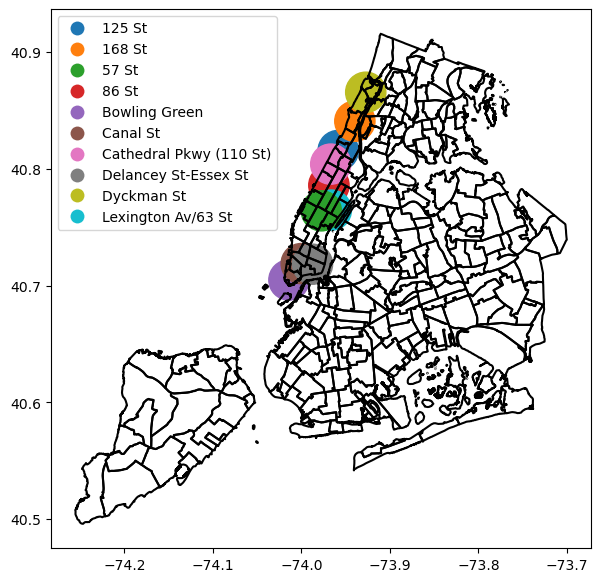

In [68]:
fig,ax = plt.subplots(figsize=(7,7))
nta_map.boundary.plot(ax=ax, edgecolor='k');
test_geo_DF[test_geo_DF.Borough == 'M']\
            .head(10)\
            .plot(column='Stop Name', ax=ax, legend=True, marker='.',\
            markersize=test_geo_DF.arrest_pct_total.astype('float') * 10000);

In [80]:
nta_demos = pandas.read_excel('https://www1.nyc.gov/assets/planning/download/office/planning-level/nyc-population/acs/demo_2019_acs5yr_nta.xlsx')

In [81]:
nta_df = nta_map.merge(nta_demos, how='left', left_on='NTA2020', right_on='GeoID')

In [70]:
test_geo_DF.to_file("test_geo.json", driver="GeoJSON")

In [ ]:
m = leafmap.Map(center=(40,-100),zoom=4)
m.add_gdf(nta_df, layer_name='2020 NTA Demographic Information', info_mode='on_click')
m.add_point_layer(filename=r'C:\Users\Nigel\Github\big-data-project\test_geo.json', popup=['Stop Name', 'arrests', 'arrest_pct_total'], layer_name="Stations")
m